#2018

##Reading in data

In [15]:
# Pandas is used for data manipulation
import pandas as pd

# Read in data as pandas dataframe and display first 5 rows
features = pd.read_csv('/content/SF data summary backfiled.csv')
features.tail(3)

,Date,House_Price_Index(S&P/Case-Shiller),Mortgage_Rate (30 yers),Personal_Income,Resident_Population,Unemployment_Rate,GDP,Crime_Rate,Percent_With_Mortgage_Debt,Median_Debt,Percent_With_Severely_Delinquent_Debt,New_Structures,Economic_Conditions_Index,CPI less shelter
163,10/1/2018,267.767739,4.83,104921,4731.803,2.7,591945.456,690.8945,33.90%,374849,0.40%,1262,3.45,248.281
164,11/1/2018,266.336767,4.87,104921,4731.803,2.6,591945.456,690.8945,33.90%,374849,0.40%,776,3.39,247.939
165,12/1/2018,263.919019,4.64,104921,4731.803,2.7,591945.456,690.8945,33.90%,374849,0.40%,2921,3.00,247.939


In [16]:
dates = features['Date']
days = [] 
months = []
years = []
for x in dates:
  date = x.split('/')
  months.append(int(date[0]))
  days.append(int(date[1]))
  years.append(int(date[2]))

In [17]:
mort_debt = features['Percent_With_Mortgage_Debt']
new_mort_debt = []
for x in mort_debt:
  new_mort_debt.append(float(x[:-1]))
features = features.drop('Percent_With_Mortgage_Debt', axis = 1)
features['Percent_With_Mortgage_Debt'] = new_mort_debt

In [18]:
del_debt = features['Percent_With_Severely_Delinquent_Debt']
new_del_debt = []
for x in del_debt:
  new_del_debt.append(float(x[:-1]))
features = features.drop('Percent_With_Severely_Delinquent_Debt', axis = 1)
features['Percent_With_Severely_Delinquent_Debt'] = new_del_debt

##Creating train and test sets

In [19]:
import numpy as np

# Use numpy to convert to arrays
# Labels are the values we want to predict
labels = np.array(features['House_Price_Index(S&P/Case-Shiller)'])
dates = np.array(features['Date'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('House_Price_Index(S&P/Case-Shiller)', axis = 1)
features= features.drop('Date', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)
#features[143][0]

In [20]:
#creating train and test sets
train_features = features[:154,:]
test_features = features[154:,:]
train_labels = labels[:154]
test_labels = labels[154:]

In [21]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (154, 12)
Training Labels Shape: (154,)
Testing Features Shape: (12, 12)
Testing Labels Shape: (12,)


##Creating a random forest regressor, training, and testing it

In [22]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels);

In [23]:
#trying out a regressor with different hyperparameters
rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, 
                               min_samples_split = 2, min_samples_leaf = 1) 

In [24]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2)) #omg wait that's not a lot of error I think

Mean Absolute Error: 25.13


In [25]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') #woah that is quite accurate....

Accuracy: 90.5 %.


##Visualizing one decision tree

In [26]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png'); 

In [27]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 12


##Variable importance

In [28]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Percent_With_Severely_Delinquent_Debt Importance: 0.93
Variable: Crime_Rate           Importance: 0.02
Variable: Personal_Income      Importance: 0.01
Variable: Resident_Population  Importance: 0.01
Variable: Unemployment_Rate    Importance: 0.01
Variable: GDP                  Importance: 0.01
Variable: Median_Debt          Importance: 0.01
Variable: Mortgage_Rate (30 yers) Importance: 0.0
Variable: New_Structures       Importance: 0.0
Variable: Economic_Conditions_Index Importance: 0.0
Variable: CPI less shelter     Importance: 0.0
Variable: Percent_With_Mortgage_Debt Importance: 0.0


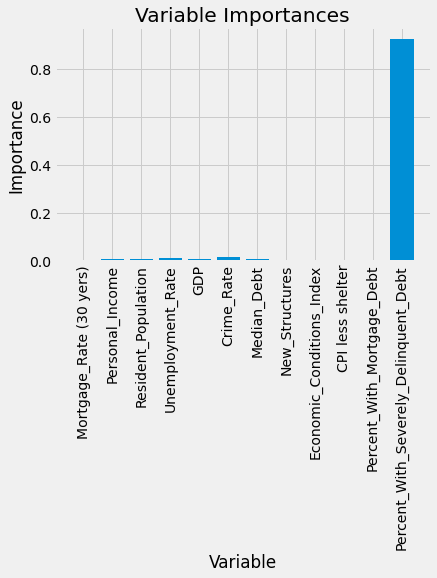

In [29]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

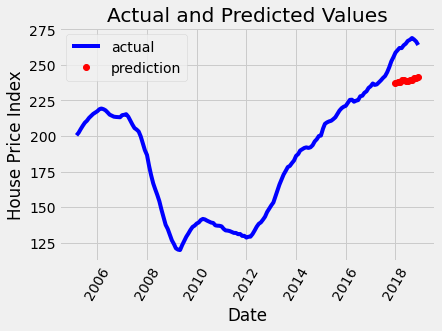

In [31]:
# Use datetime for creating date objects for plotting
import datetime

# Dates of training values
m1 = months
d1 = days
y1 = years

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(y1, m1, d1)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# Dates of predictions
m2 = months[154:]
d2 = days[154:]
y2 = years[154:]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(y2, m2, d2)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})

predictions_data.to_csv('/content/rf_sf_test.csv')

# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('House Price Index'); plt.title('Actual and Predicted Values');

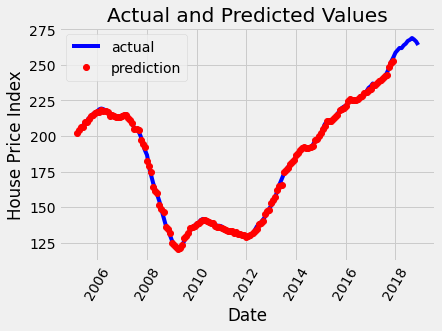

In [32]:
# Use datetime for creating date objects for plotting
import datetime

# Dates of training values
m1 = months
d1 = days
y1 = years

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(y1, m1, d1)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# Dates of predictions
m2 = months[:154]
d2 = days[:154]
y2 = years[:154]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(y2, m2, d2)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions = rf.predict(train_features)
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})

predictions_data.to_csv('/content/rf_sf_train.csv')

# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('House Price Index'); plt.title('Actual and Predicted Values');

#2013

##train and test sets

In [ ]:
#creating train and test sets
train_features_1, test_features, train_features_2 = np.split(np.array(features),[22,46])
train_features = np.concatenate((train_features_1, train_features_2))

train_labels_1, test_labels, train_labels_2 = np.split(np.array(labels),[22,46])
train_labels = np.concatenate((train_labels_1, train_labels_2))

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (142, 12)
Training Labels Shape: (142,)
Testing Features Shape: (24, 12)
Testing Labels Shape: (24,)


##training rf

In [ ]:
rf.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2)) #omg wait that's not a lot of error I think

Mean Absolute Error: 5.85


In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') #woah that is quite accurate....

Accuracy: 96.59 %.


##variable importance

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Percent_With_Severely_Delinquent_Debt Importance: 0.51
Variable: Unemployment_Rate    Importance: 0.33
Variable: Personal_Income      Importance: 0.04
Variable: Crime_Rate           Importance: 0.04
Variable: Resident_Population  Importance: 0.03
Variable: GDP                  Importance: 0.03
Variable: Median_Debt          Importance: 0.01
Variable: Percent_With_Mortgage_Debt Importance: 0.01
Variable: Mortgage_Rate (30 yers) Importance: 0.0
Variable: New_Structures       Importance: 0.0
Variable: Economic_Conditions_Index Importance: 0.0
Variable: CPI all items less shelter Importance: 0.0


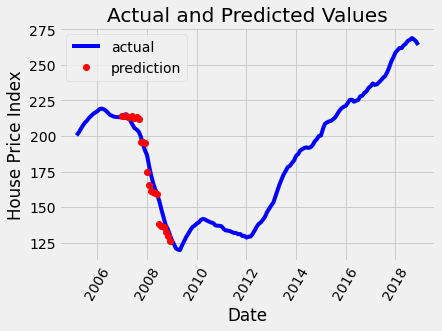

In [ ]:
# Use datetime for creating date objects for plotting
import datetime

# Dates of training values
m1 = months
d1 = days
y1 = years

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(y1, m1, d1)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# Dates of predictions
m2 = months[22:46]
d2 = days[22:46]
y2 = years[22:46]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(y2, m2, d2)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})

# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('House Price Index'); plt.title('Actual and Predicted Values');

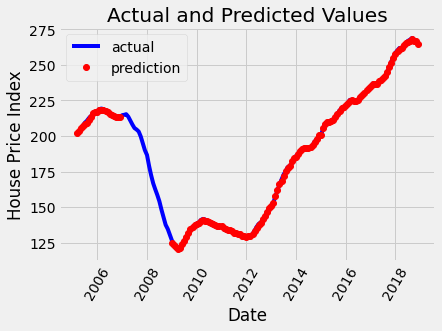

In [ ]:
# Use datetime for creating date objects for plotting
import datetime

# Dates of training values
m1 = months
d1 = days
y1 = years

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(y1, m1, d1)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# Dates of predictions
m2 = np.concatenate((months[:22],months[46:]))
d2 = np.concatenate((days[:22],days[46:]))
y2 = np.concatenate((years[:22],years[46:]))

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(y2, m2, d2)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions = rf.predict(train_features)
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})

# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('House Price Index'); plt.title('Actual and Predicted Values');